In [ ]:
# #Pre-requisites
# Upload the '/'content/trained_model.h5'
# Upload the images directory
# Install the below libraries

In [ ]:
#IDE Used
#Colab to make use of the GPU for Tensorflow

In [1]:
#Librries to be installed
!pip install tensorflow
!pip install opencv-python-headless

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


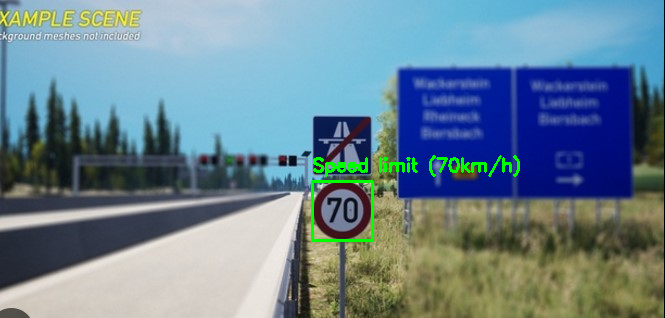

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


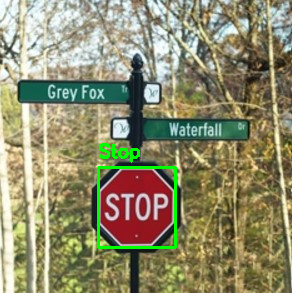

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


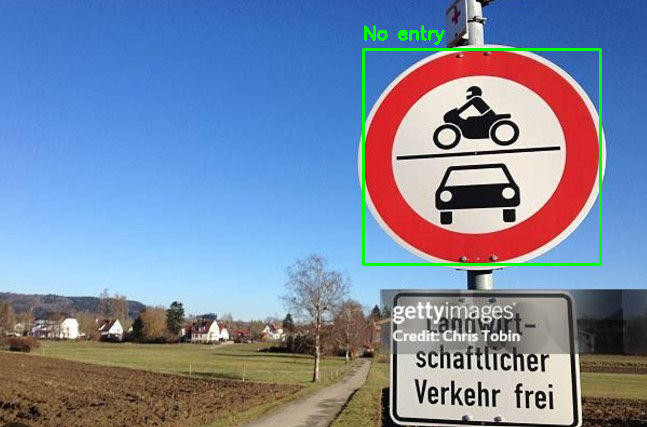

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


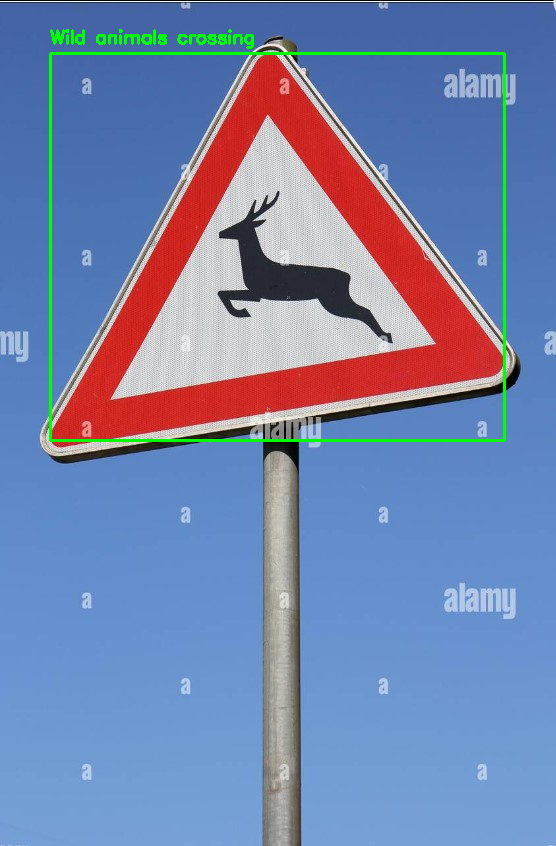

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


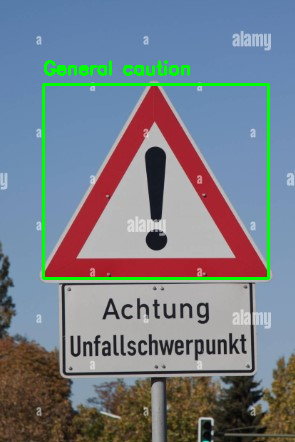

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


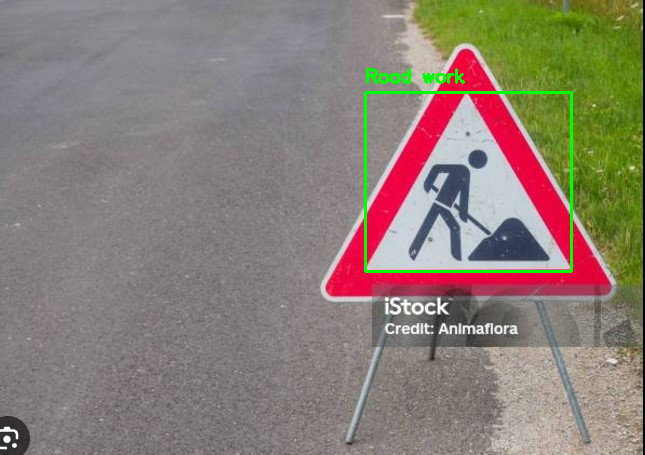

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


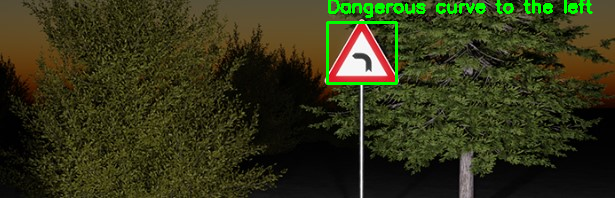

In [3]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow

# Load pre-trained traffic sign classification model
model = load_model("trained_model.h5")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
class_names = ['Speed limit (20km/h)', 'Speed limit (30km/h)',
               'Speed limit (50km/h)', 'Speed limit (60km/h)',
               'Speed limit (70km/h)', 'Speed limit (80km/h)',
               'End of speed limit (80km/h)', 'Speed limit (100km/h)',
               'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons',
               'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles',
               'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left',
               'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right',
               'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow',
               'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead',
               'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory',
               'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']

# preprocess frame for classification
def preprocess_frame(roi):
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi = cv2.resize(roi, (32, 32))  # Resize to match model input
    roi = roi.astype("float32") / 255.0  # Normalize
    roi = img_to_array(roi)  # Convert to array
    roi = np.expand_dims(roi, axis=-1)  # Add the channel dimension
    roi = np.expand_dims(roi, axis=0)   # Add the batch dimension
    return roi

# detect shapes (filtering out unnecessary small contours)
def detect_shapes(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area to remove noise
    filtered_contours = [c for c in contours if cv2.contourArea(c) > 500]
    return filtered_contours

# Main function: process series of images
def process_images(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        frame = cv2.imread(image_path)

        # Handle cases where the image fails to load
        if frame is None:
            print(f"Error: Unable to load image from {image_path}")
            return

        contours = detect_shapes(frame)
        detected = False

        for contour in contours:
            approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
            x, y, w, h = cv2.boundingRect(approx)

            # Filter for signs based on aspect ratio and size
            if not detected and w > 30 and h > 30 and 0.8 <= w / h <= 1.2:  # Approximate square or circle
                detected = True  # Mark as detected
                roi = frame[y:y + h, x:x + w]

                preprocessed_roi = preprocess_frame(roi)

                # Predict the traffic sign
                predictions = model.predict(preprocessed_roi)
                class_index = np.argmax(predictions)
                label = class_names[class_index]

                # Draw bounding box and label
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        cv2_imshow(frame)


# Run the image processing function
if __name__ == "__main__":
    image_path = "/content/sample_data/images"
    process_images(image_path)
